# Filtering with Pyleoclim

A common task that befalls the analyst is to filter timeseries to highlight signals of interest. In this notebook we illustrate how easy this is in *Pyleoclim*.

First let's import this and other useful packages, as well as the example data:

In [1]:
%load_ext autoreload
%autoreload 2
import pyleoclim as pyleo
import scipy.io as sio
pyleo.set_style('web') # set graphic style

data = sio.loadmat('../example_data/wtc_test_data_nino.mat')
air = data['air'][:, 0]
nino = data['nino'][:, 0]
t = data['datayear'][:, 0]

## 1. Setting the stage

As usual, we start by putting the data into *Pyleoclim* `Series` objects for easy manipulation

In [15]:
ts_air = pyleo.Series(time=t, value=air, value_name='Index', time_name='Time', time_unit='yr')
ts_nino = pyleo.Series(time=t, value=nino, value_name='SST anom.', value_unit='K', time_name='Time', time_unit='yr')

Now that the objects are defined, it's ready to do some visualization.
Note that the visualization style has been automatically customized when we import the *Pyleoclim* package. 

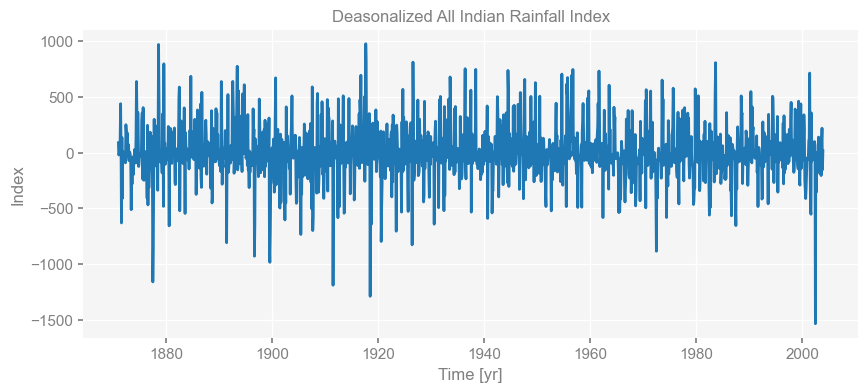

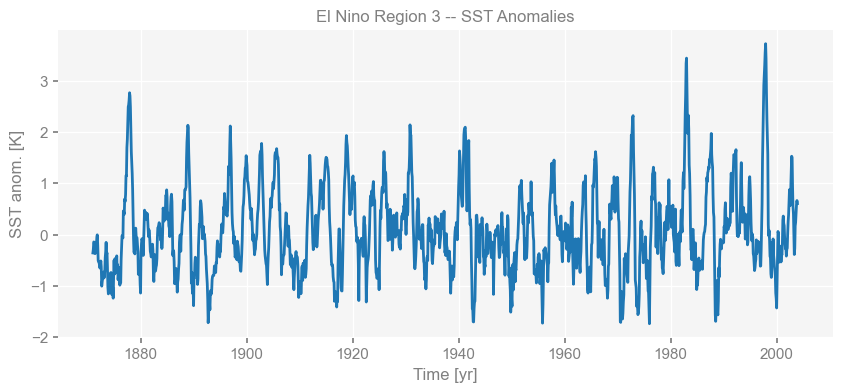

In [16]:
fig, ax = ts_air.plot(title='Deasonalized All Indian Rainfall Index')
fig, ax = ts_nino.plot(title='El Nino Region 3 -- SST Anomalies')

There are many ways to assess relationships between series. At high frequency there is no obvious relationship, as can be found when applying causality analysis (cf `pyleoclim_ui_tutorial.ipynb`).  But what about relationships at timescales longer than 1 years ("interannual"), specifically the canonical ENSO band of 2-7 years? To assess questions of this nature (and others), *Pyleoclim* facilitates 2 sorts of filter:  (1) frequency-based filters and (2) time-based filters.

## 2. frequency-based filters

The most common form of filters in the digital age act in the frequency domain. These Frequency-based filters work by explicitly suppressing or enhancing the original signal in certain frequency bands. There is a very large literature 

### 2.1 lowpass filtering



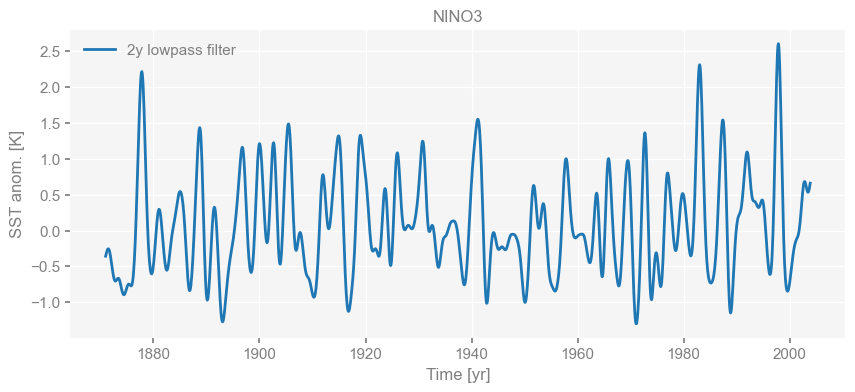

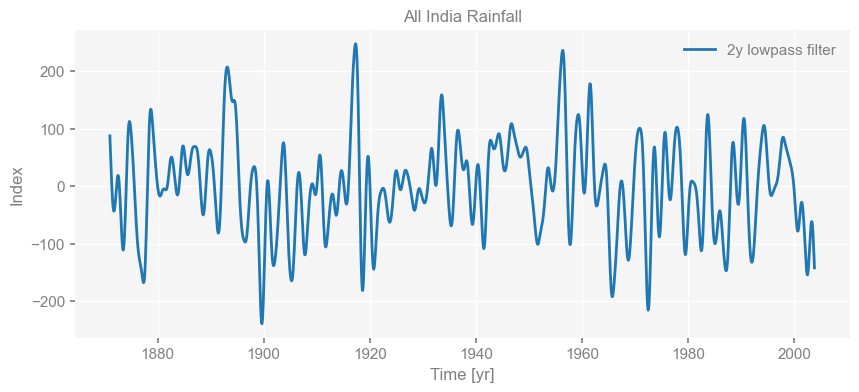

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:title={'center':'All India Rainfall'}, xlabel='Time [yr]', ylabel='Index'>)

In [69]:
nino_i = ts_nino.interp()
nino_low = nino_i.filter(cutoff_scale=2)
f1, ax1 = nino_low.plot(title='NINO3',label='2y lowpass filter')
air_i = ts_air.interp()
air_low = air_i.filter(cutoff_scale=2)
air_low.plot(title='All India Rainfall', label='2y lowpass filter')

Now it is easier to see how there might be similarities between the two series. To be more quantitative, we can use _Pyleoclim_'s correlation method: 



In [24]:
corr = nino_low.correlation(air_low)
print(corr)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
    -0.440157  < 1e-6     True



The anticorrelation is much stronger than before (-.044 vs -0.15), and highly significant (p-value is extremely low, even with the conservative test of Ebisuzaki, which is applied by default when calling `correlation()`).

Note that filtering behavior is generally controlled by a cutoff frequency ($f_c$), implemented in `filter()` as `cutoff_freq`. However, we find it more intuitive to specify a cutoff scale (e.g. 2 years), which is what was done here with the `cutoff_scale=2` specification. Both are equivalent, and you need only use one, of course.

### 2.2 Bandpass filtering

The next logical question would be: is this correlation mostly happening in the the ENSO band (2-7 years), or does it also apply at lower frequencies? To address this question, one would apply a 2-7 year  *bandpass* filter, which you would do like so:

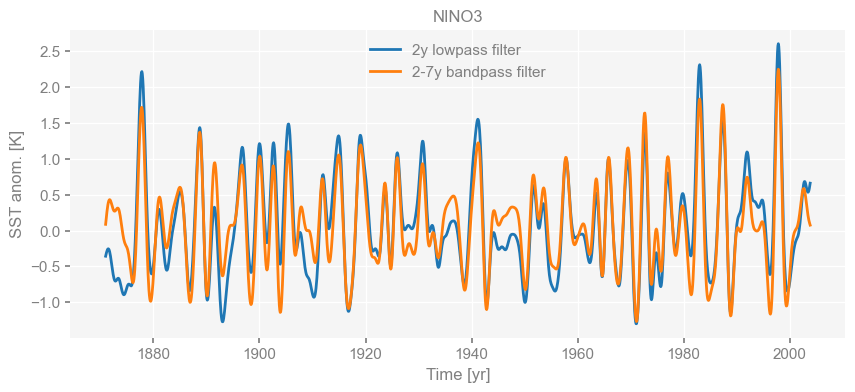

In [25]:
nino_bp = nino_i.filter(cutoff_scale=[2,7])
nino_bp.plot(label='2-7y bandpass filter',ax=ax1)
pyleo.showfig(f1)

Notice how we only had to specify the list `[2,7]` as the argument of `cutoff_scale`. This did get rid of the longer wavelength components, while emphasizing [well-known events](https://psl.noaa.gov/enso/past_events.html).  Again, let's look at correlations:

In [28]:
air_bp = air_i.filter(cutoff_scale=[2,7])

corr_bp = nino_bp.correlation(air_bp)
print(corr_bp)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     -0.47972  < 1e-6     True



We see that the correlation increases slightly (in absolute value), confirming that the relationship between NINO3 SST and all India rainfall is mainly the result of interannual-scale processes.

### 2.3 Filter types

There are dozens of filter types available, each solving a particular optimization problem. These choices can be highly consequential in acoustics and electrical engineering, for instance, where they can make the difference between cheap and expensive sound gear. Pyleoclim implements four major filter types:

1. a [zero-phase](https://www.dsprelated.com/freebooks/filters/Forward_Backward_Filtering.html) **Butterworth filter**: invoking `ts.filter(method = 'butterworth')` on timeseries object `ts` will implement a backward-forward Butterworth filter, often used because of its good compromise between frequency response and relatively small impulse response. The backward-forward application ensures zero phase distortion, but squares the amplitude response (e.g. a 3rd order filter - the default - becomes effectively 6th order). 

1. **Finite impulse response (FIR) filter**: this follows the [SciPy implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html) and gives access to an extensize menu of [windows](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html#scipy.signal.get_window) (the default is a [Hamming](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.hamming.html#scipy.signal.windows.hamming) window). For most paleoclimate applications, window choices should make little difference. If they do, you need to be very careful about what inference you make from those filtered series. The phase response may be consequential if you are trying to assess lead-lag relationships, so make sure the series in question are uniformly treated.

1. **Lanczos** filter: a finite-sample approximation of the sinc function, the  **Lanczos** filter has long been proposed as a practical implementation of digital filtering for climate timeseries (see [Duchon, 1979](https://journals.ametsoc.org/view/journals/apme/18/8/1520-0450_1979_018_1016_lfioat_2_0_co_2.xml)). It is accessible through `ts.filter(method = 'butterworth')`.  


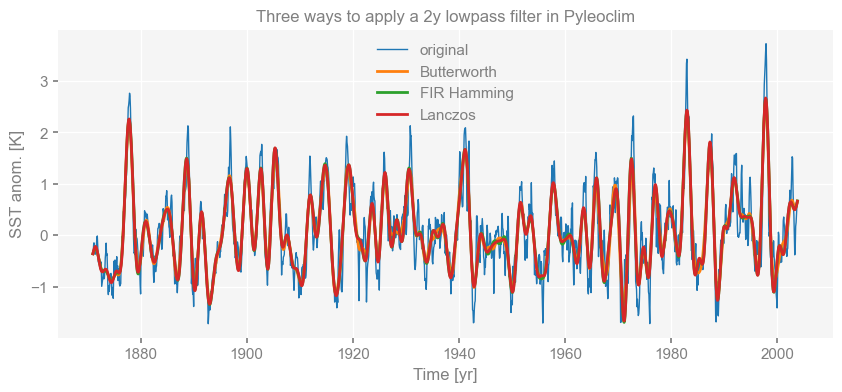

In [42]:
f2, ax2 = nino_i.plot(title='Three ways to apply a 2y lowpass filter in Pyleoclim',label='original',linewidth=1,mute=True)
nino_low.plot(label='Butterworth',ax=ax2)
nino_i.filter(method = 'firwin',cutoff_scale = 2).plot(label='FIR Hamming',ax=ax2)
nino_i.filter(method = 'lanczos',cutoff_scale = 2).plot(label='Lanczos',ax=ax2)
pyleo.showfig(f2)

As can be seen above, the differences are minimal in this case, but we recommend as usual trying several approaches and seeing if that makes a difference with your data. `Pyleoclim` is designed to make that process painless.

### 2.4 Dealing with edge effects

Part of the uncertainty principle is that all filters with good frequency properties have a non-zero temporal footprint (the "Impulse Response), which may introduce spurious wiggles in the filtered series. This can be particularly problematic near the edges, as Fourier method implicitly wrap a series around itself (it's not a conspiracy theory, it's the TRUTH! Follow @DigitalSignalProcessingDisclosures for more explosive revelations). One method to minimize edge effects is to taper the series. Another is to pad it, but the question then becomes how to sensibly pad it. 

The method `ts_pad()` does this in two ways:
- `reflect` imposes a reflection condition
- `ARIMA` fits an [ARIMA model](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html) to the data and uses to predict its fluctuations on either side. 

By default, both methods extend the series by 10% on either side. To see why edge effects might matter, let's engineer the series so its beginning and endpoints are far apart (by deviously selecting them for dramatic effect): 

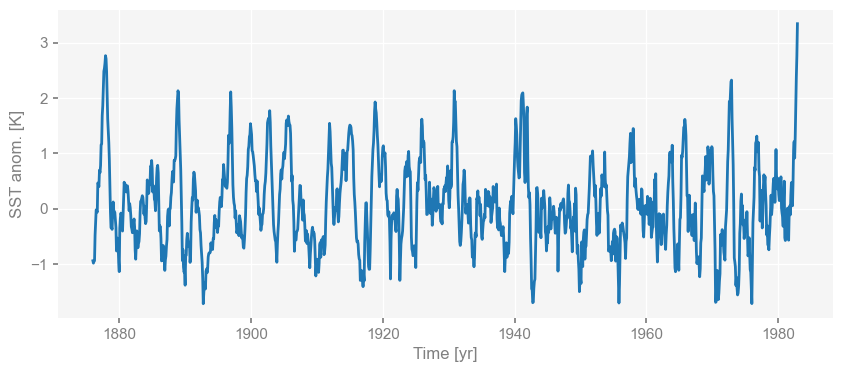

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Time [yr]', ylabel='SST anom. [K]'>)

In [45]:
nino_s = nino_i.slice([1876,1983])
nino_s.plot()

In such a case it may be necessary to set the `pad` parameter carefully. We leave this as an exercise for the reader.

## 3. Time-based filters

Frequency-based filters operate allow great control over the frequency response of the filter. However, that is not always desirable or necessary. In some applications, emipirical time-based filtering techniques may be just as powerful, even more so. 

### 3.1 Savitzky-Golay filter

The Savitzky-Golay filter is a least-squares method fitting a low-order polynomial (default order is 2) to the data to remove high frequency oscillations. It has the advantage of preserving the original shape and features of the signal better than other types of filtering  approaches, such as moving averages techniques. The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point. It is typically used in Pyleoclim for isolating a nonlinear trend to be removed from the data prior to e.g. spectral analysis, but can be put to many other uses. Its only control parameter is the length of the filter window, which must be a positive integer). 
    
First, let us use it to lowpass filter at 2 years, as before:    

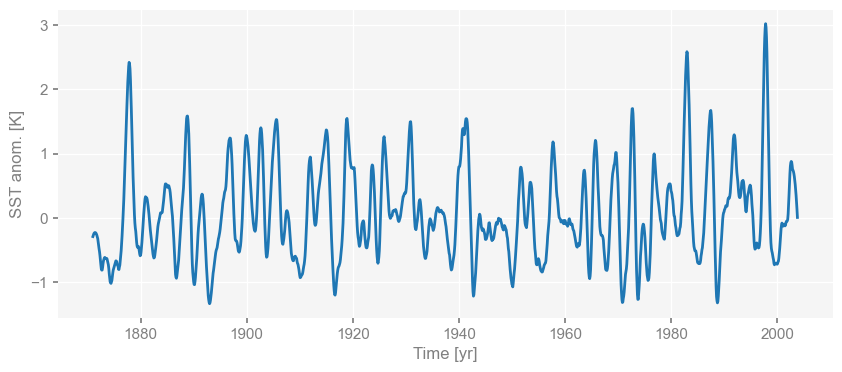

In [54]:
nino_sg = nino_i.filter(method='savitzky-golay',cutoff_scale=2).plot()

It works, but it is noticeably noisier than previous methods, and you'd see a lot of ugly stuff in that filter's frequency response. Where SG shines, however, is in its ability to isolate long-term trends. Here it is at working isolating a centennial trend:

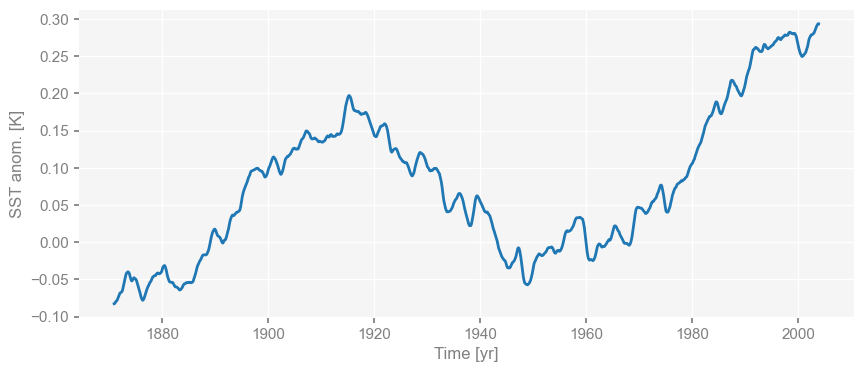

In [60]:
nino_sg = nino_i.filter(method='savitzky-golay',cutoff_scale=100, mode='mirror').plot()

Indeed, SG is also enabled for [detrending](https://pyleoclim-util.readthedocs.io/en/stable/utils/tsutils/detrend.html) in `pyleoclim'.

### 3.2 Singular Spectrum analysis

An alternative filtering method that may be useful in the climate sciences is Singular Spectrum Analysis ([SSA](./singular_spectrum_analysis.ipynb)). SSA enjoys an interpretation from dynamical systems theory (see Vautard & Ghil 1989), where it can be seen as estimating the skeleton of the system's attractor. SSA decomposes a series in a linear combination of eigenoscillations (modes); typically, the first few such modes account for the vast majority of the variance, and in many cases, they also tend to carry the most low-frequency energy. Reconstructing a timeseries on the basis of these few modes will therefore naturally emphasize the important and smooth components of a signal, without having to explicitly pick a frequency band. 

SSA is introduced at greater length in ([this notebook](./singular_spectrum_analysis.ipynb)), so here we focus on its filtering capabilities.  SSA implements 3 methods to approximate the timeseries:
- **a variance-based criterion** that simply retains the first $m$ modes adding up to a certain fraction `var_tresh` of the total series variance. This is the simplest method imaginable, but because geophysical timeseries tend to be "red" (dominated by slow undulations), picking the first few modes typically acts as a rather effective filter against high-frequency noise.

- **the Kaiser-Guttman rule**, which asserts that the modes that matter are those whose eigenvalue is above the mean (or median) of the eigenvalues. 

- **Monte Carlo SSA**, which evaluates a series' eigenvalue spectrum against that of an ensemble (typically, 1000) of red-noise processes (more properly, autoregressive processes of order 1). 

This last method is more computationally intensive, but more rigorous in selecting modes that rise above what one would expect from a a random AR(1) process. 

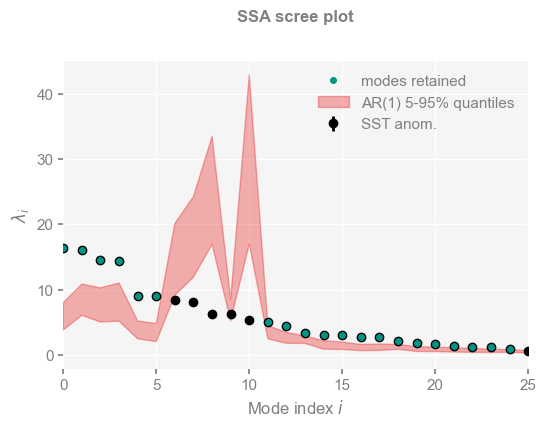

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:title={'center':'SSA scree plot'}, xlabel='Mode index $i$', ylabel='$\\lambda_i$'>)

In [61]:
ninoSsa = nino_i.ssa(trunc='mcssa',nMC=1000)
ninoSsa.screeplot(xlim=[0, 25])

We see that the method selects the first 6 modes, skips the next 5, then picks a another dozen or so. For the full list, type:

In [73]:
ninoSsa.mode_idx

array([ 0,  1,  2,  3,  4,  5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 37, 38, 39])

Let us look at the resulting timeseries, which we can access from the `RCseries` array in the result object:

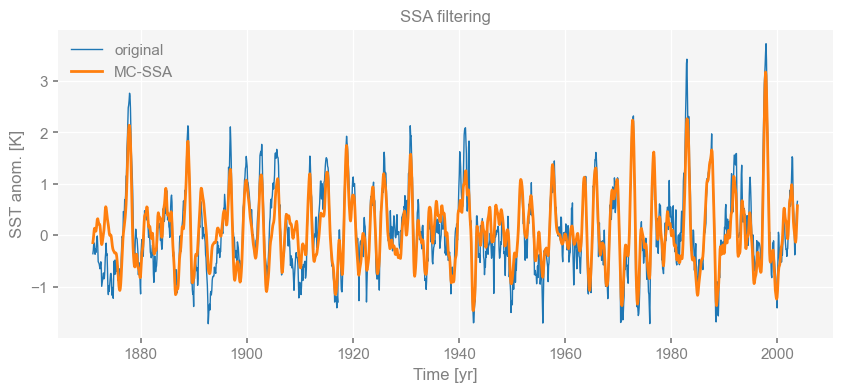

In [74]:
f3, ax3 = nino_i.plot(title='SSA filtering',label='original',linewidth=1, mute=True)
nino_ssa1 = nino_i.copy()
nino_ssa1.value=ninoSsa.RCseries
nino_ssa1.plot(ax=ax3,label='MC-SSA')
pyleo.showfig(f3)

In [72]:
var_frac = ninoSsa.pctvar[ninoSsa.mode_idx].sum()
print(var_frac)

83.26880140279624


The command above allows to see what fraction of the original variance is captured by those modes. Out of curiosity, let us compare this to using the variance criterion with a threshold set at 83.27%:

In [76]:
ninoSsa2 = nino_i.ssa(trunc='var',var_thresh=var_frac)

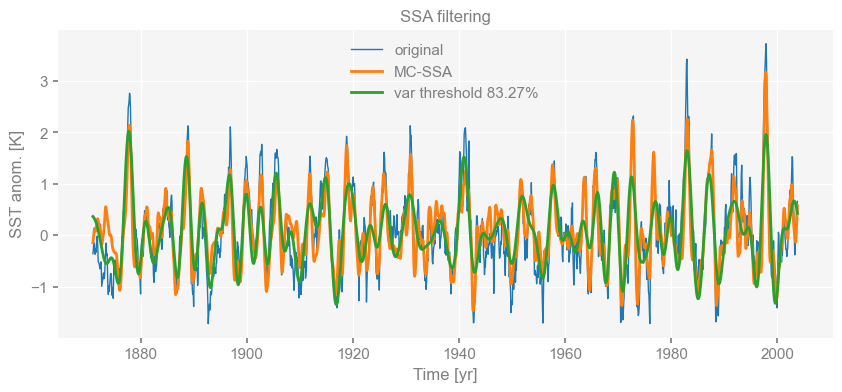

In [77]:
nino_ssa2 = nino_i.copy()
nino_ssa2.value=ninoSsa2.RCseries
nino_ssa2.plot(ax=ax3,label='var threshold 83.27%')
pyleo.showfig(f3)

We see that it missed many of the finer-scale oscillations, particularly those associated with strong ENSO events (e.g. the 1997/98 event). Finally, let us see what the Kaiser-Guttman criterion would yield:

In [78]:
ninoSsa3 = nino_i.ssa(trunc='kaiser')

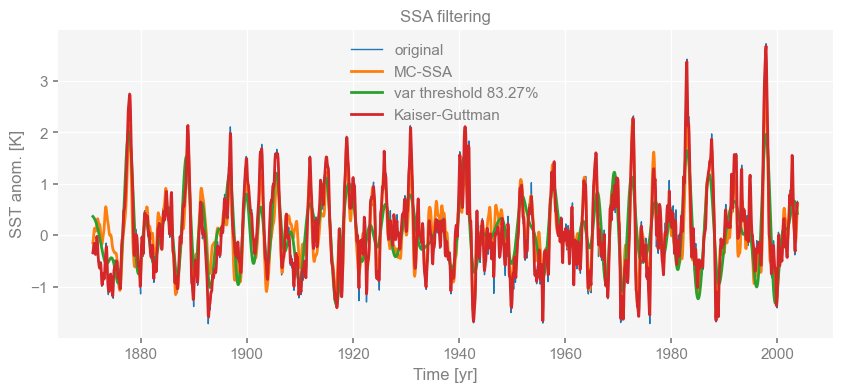

In [80]:
nino_ssa3 = nino_i.copy()
nino_ssa3.value=ninoSsa3.RCseries
nino_ssa3.plot(ax=ax3,label='Kaiser-Guttman')
pyleo.showfig(f3)

In [81]:
ninoSsa3.pctvar[ninoSsa3.mode_idx].sum()

99.99641145204822

We see that in this case the Kaiser criterion effected no filtering to speak of, keep virtually all of the original variance. It does lack a theoretical rationale, and we can see why that matters. It does not perform that dismally in all cases, so please don't judge it harshly. The [SSA notebook](./singular_spectrum_analysis.ipynb) (last section) shows it in a better light.

That's our show! See you in the next notebook.